## InceptionNet

        This model is implmented using transfer learning approach by using InceptionNet architecture. InceptionNet is also called GoogleNet and very popular for image processing. Other Transfer learning architecture improves the height of the model by adding more layers but inceptionnet improves the width horizontally at one single it applied 4 types of convolution on images to capture the sophisticated shapes and detect the pattern.Therefore, we are using this architecture for detecting deepfake and real images.

**Step 1: Importing libraries**

In [6]:
import os, datetime
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

**Step 2: Image Data Generator For Train dataset.**

In [2]:
# Path of directory where image dataset is stored
base_path ='kaggle image/real-vs-fake/'

#Image data generator for reading train data images with batch size of 64.
image_gen = ImageDataGenerator(rescale=1./255.)

train_data = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size = 64,
    class_mode ='binary'
)
print("Training Data Classes :",train_data.class_indices)

Found 100000 images belonging to 2 classes.
Training Data Classes : {'fake': 0, 'real': 1}


**Step 3: Image Data Generator For validation dataset.**

In [3]:
#Image data generator for reading validation data images with batch size of 64.
image_gen_valid = ImageDataGenerator(rescale=1./255.)

valid_data = image_gen_valid.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size= 64,
    class_mode = 'binary'
)
print("validation Data Classes :",valid_data.class_indices)

Found 20000 images belonging to 2 classes.
validation Data Classes : {'fake': 0, 'real': 1}


**Step 4: Image Data Generator For Test dataset.**

In [7]:
#Image data generators for reading test data image with batch size of 1.
image_gen_test = ImageDataGenerator(rescale=1./255.)

test_data = image_gen_test.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size= 1,
    shuffle= False,
    class_mode = 'binary'
)
print("Test Dataset classes:",test_data.class_indices)

Found 20000 images belonging to 2 classes.
Test Dataset classes: {'fake': 0, 'real': 1}


**Step 5: Input Image Data Samples of Real and Fake class.**

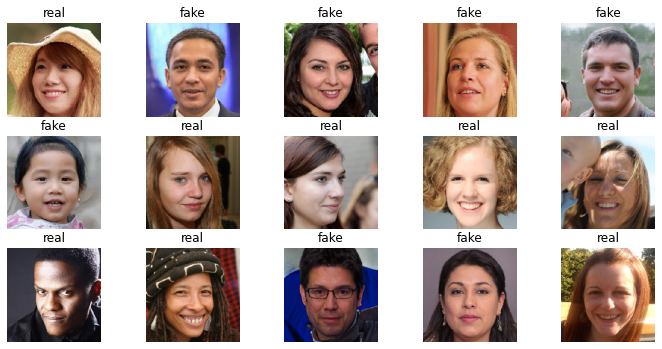

In [8]:
# Below are the image samples of real and fake images which looks exactly similar.
plt.figure(figsize=(12,10))
for i in range(15):
    img, label = train_data.next()
    ax = plt.subplot(5,5, i+ 1)
    plt.imshow(img[0])
    if (label[0]) == 0.0:
        plt.title("fake")
    else:
        plt.title("real")
    plt.axis('off')

**Step 6: InceptionNet Model Architecture.**

        While training the InceptionNet model, we have used 'imagenet', this are pretrained weights of the images which is trained using 14 million images.

In [9]:
base_model = InceptionV3(input_shape = (224, 224, 3),
                         include_top = False, 
                         weights = 'imagenet')

2022-09-07 00:26:32.206999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 00:26:34.555351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2022-09-07 00:26:34.556823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30998 MB memory:  -> device: 1, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2022-09-07 00:26:34.558185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/r

**Step 7:In below section turned off the learning, weights of imagenet**

        In below cells, we have turned off the training of the weights of the 14 million images included in imageNet. so we do not need to retrain it again in our model.

In [10]:
for layer in base_model.layers:
    layer.trainable = False

**We have added extra layers  and sigmoid activation function on top of inceptionnet to make classification decision**

In [11]:
extra_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
extra_layer = tf.keras.layers.Flatten()(extra_layer)
extra_layer = tf.keras.layers.Dense(1024, activation='relu')(extra_layer)
extra_layer = tf.keras.layers.Dropout(0.2)(extra_layer)

# Add a final sigmoid layer with 1 node for classification output
extra_layer = tf.keras.layers.Dense(1, activation='sigmoid')(extra_layer)

#merged extra layers with base model of "InceptionNet"
model = tf.keras.models.Model(base_model.input, extra_layer)


**Step 8: Defined Compiler for model training.**

In [13]:
# We are calculating loss, using binar cross entropy and utilizing Adam optimizer for loss optimization and also using 
# Binary accuracy metric for accuracy.

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

model.compile(optimizer= opt,
              loss=binary_crossentropy,
              metrics=[keras.metrics.BinaryAccuracy()])

In [14]:
#Model.summary give the summary of the total layers included in the entire model architecture.

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Step 9 :  Model is learning from train data in specified number of steps.

In [15]:
#Below defined the no of epochs and step per epoch for model training and validation steps for hyperparameter tuning.
from tensorflow.python.ops.gen_batch_ops import batch


train_steps = 10000// 64
valid_steps = 20000// 64


history = model.fit(
    train_data,
    epochs=10,
    steps_per_epoch = 1000,
    validation_data = valid_data,
    validation_steps = 250
)
          

2022-09-07 00:27:38.282124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-07 00:27:42.028301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-09-07 00:27:42.434052: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 00:27:42.434846: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 00:27:42.434874: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-09-07 00:27:42.435684: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 00:27:42.435840: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1000/1000 [==============================] - 496s 491ms/step - loss: 0.5437 - binary_accuracy: 0.7305 - val_loss: 0.4798 - val_binary_accuracy: 0.7671
Epoch 2/10
1000/1000 [==============================] - 326s 326ms/step - loss: 0.4726 - binary_accuracy: 0.7725 - val_loss: 0.4825 - val_binary_accuracy: 0.7666
Epoch 3/10
1000/1000 [==============================] - 285s 285ms/step - loss: 0.4506 - binary_accuracy: 0.7893 - val_loss: 0.4478 - val_binary_accuracy: 0.7878
Epoch 4/10
1000/1000 [==============================] - 248s 247ms/step - loss: 0.4308 - binary_accuracy: 0.8013 - val_loss: 0.4431 - val_binary_accuracy: 0.7917
Epoch 5/10
1000/1000 [==============================] - 284s 284ms/step - loss: 0.4163 - binary_accuracy: 0.8086 - val_loss: 0.4100 - val_binary_accuracy: 0.8128
Epoch 6/10
1000/1000 [==============================] - 252s 252ms/step - loss: 0.4021 - binary_accuracy: 0.8189 - val_loss: 0.4118 - val_binary_accuracy: 0.8116
Epoch 7/10
1000/1000 [=================

**Step 10: Saving the model**

In [23]:
model.save('inceptionnet_model_architecture.h5')

**Step 11: Defining Function for plotting accuracy and loss.**

In [24]:
# using below finction, we plotting accuracy,validation accuracy and also loss and validation loss for performing analysis.
def accuracy_graph(no_of_epochs, accuracy, val_accuracy):
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set(facecolor = "black")
    ax.plot(no_of_epochs, acc, 'blue', linewidth=1, marker='o', label='Training accuracy')
    ax.plot(no_of_epochs, val_acc, 'orange', linewidth=1, marker='o', label = 'Validation accuracy')
    ax.set_title('Training and Validation Accuracy using Custom CNN Model')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()

    

def loss_graphs(no_of_epochs, loss, val_loss): 
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set(facecolor = "black")
    ax.plot(no_of_epochs, loss, 'blue', linewidth=1, marker='o', label='Training Loss')
    ax.plot(no_of_epochs, val_loss, 'orange', linewidth=1, marker='o', label = 'Validation Loss')
    ax.set_title('Training and Validation Loss using Custom CNN Model')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()

**Step 12: Storing Train and Validation set accuracy and loss**

In [25]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

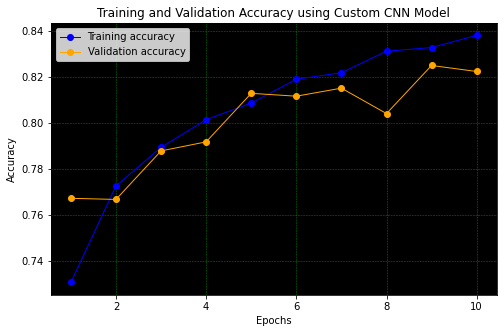

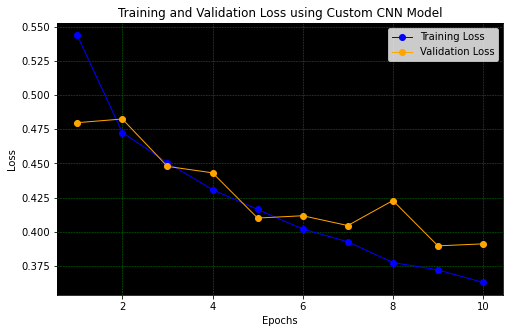

In [26]:
# calling the above defined function for plotting loss and accuracy.
accuracy_graph(range(1, len(loss) + 1), acc, val_acc)
loss_graphs(range(1, len(loss) + 1), loss, val_loss)

**Step 13: Calculating Prediction on Test Data set**

In [27]:
#We are using same trained model, for predicting labels of test image data.
y_pred = model.predict(test_data)
y_test = test_data.classes

**Step 14: Calculating Classification Report**

In [32]:
#for model evaluation, using classfication report which shows, precision, recall, F1-score.
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred> 0.5))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     10000
           1       0.85      0.80      0.82     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



**Step 15: Confusion Matrix result**

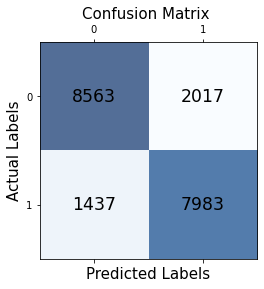

In [31]:
#Also plotting confusion matrix, for checking True positive, True Negative , False positive and False negative values based
# on the model prediction

Confusion_matrix = metrics.confusion_matrix(y_test, y_pred> 0.5)
fig, px = plt.subplots(figsize=(4, 4))
px.matshow(Confusion_matrix, cmap=plt.cm.Blues, alpha = 0.7)
for row in range(Confusion_matrix.shape[0]):
    for col in range(Confusion_matrix.shape[1]):
        px.text(x=row,y=col,s=Confusion_matrix[row, col], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('Actual Labels', fontsize=15)
plt.title('Confusion Matrix ', fontsize=15)
plt.show()

**Code References:**

1.	https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
2.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
3.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D
4.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
5.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
6.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
7.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
8.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
9.	https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
10.	https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
11.	https://www.kaggle.com/code/zohaib30/fake-vs-real-tensorflow-keras
12. https://keras.io/api/applications/densenet/
13. https://keras.io/api/applications/inceptionv3/
